In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import glob
import pandas as pd

In [2]:
#directories = glob.glob('.experiments/end-effector_tuning/*/*sigmoid*/result*.pth')
directories = glob.glob('.experiments/end-effector/*/*/result*.pth')
#load each 
results = {}
seed = 0
is_one_model = False
for pth in directories:
    dt = pth.split('/')[-1].split('-dt-')[-1].split('-')[0]
    algorithm = pth.split('/')[2] + '-' + dt
    
    result = torch.load(pth)
    if algorithm in results and not is_one_model:
        start = len(results[algorithm])
        end = len(results[algorithm]) + len(result)
        j = 0
        for i in range(start, end):
            results[algorithm][i] = result[j]
            j += 1        
    elif algorithm in results and is_one_model:
        results[algorithm + "-" + str(seed)] = result
        seed += 1
    else:
        results[algorithm] = result
    

In [3]:
results.keys()

dict_keys(['knn-neuraljacobian-results'])

# Plot Error Curves
In this section we want to see if our Jacobian estimates with our neural network actually solve the undlerying task of interest (i.e. moving the end effector to some target position)

In [4]:
def collect_eps_errs(result, dim=-1):
    err_over_time = []
    for k, value in result.items():
        episode_err = []
        for v in value:
            state = v[5] #should be....state
            if dim < 0:
                psn = state[0:3]
                targ = state[-3:]
                mse = np.linalg.norm(targ - psn, 2)
                rmse = np.sqrt(mse)
                
                #mse = rmse
            else:
                psn = state[dim]
                targ = state[-3 + dim]
                mse = np.sqrt((targ - psn) ** 2)
            episode_err.append(mse)
        err_over_time.append(episode_err)
    return np.array(err_over_time).T

def plot_mu_sig(data, label=None, axis=1, ax=None):
    samples = np.array(data)
    mean = samples.mean(axis=axis)
    std = samples.std(axis=axis)
    ste = std / np.sqrt(samples.shape[0]) #this is a hack, if axis not == 1, this will break
    
    if ax is None:
        plt.plot(mean, label=label)
        plt.fill_between(list(range(mean.shape[0])), mean + std, mean - std, alpha=0.1)
    else:
        ax.plot(mean, label=label)
        #ax.errorbar(list(range(mean.shape[0])), mean, yerr=std /np.sqrt(samples.shape[0]) , label=label)
        ax.fill_between(list(range(mean.shape[0])), mean + ste, mean - ste, alpha=0.1)

Text(0, 0.5, 'Error Decrease')

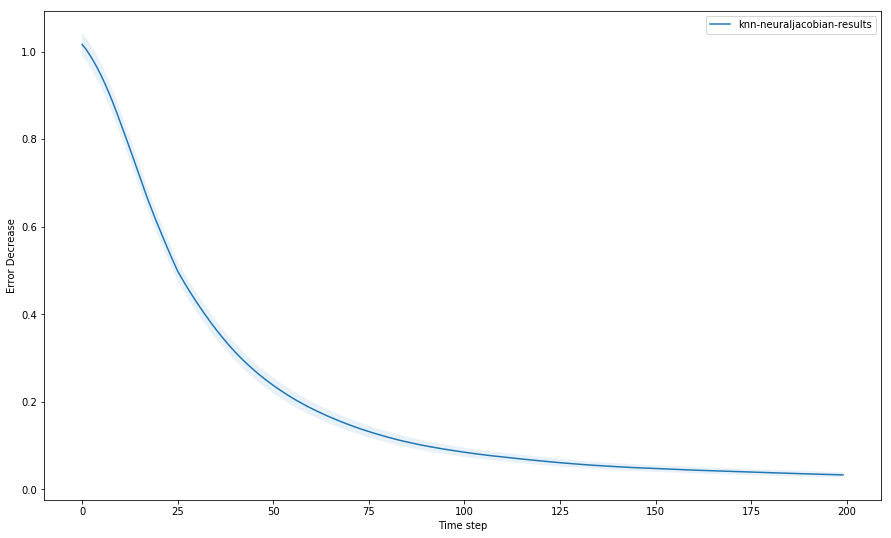

In [5]:
#load each 

fig, ax = plt.subplots(1, 1, figsize=(15, 9))
for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1)
    plot_mu_sig(err_over_time, label=algorithm, ax=ax)
    
ax.legend()
ax.set_xlabel("Time step")
ax.set_ylabel("Error Decrease")

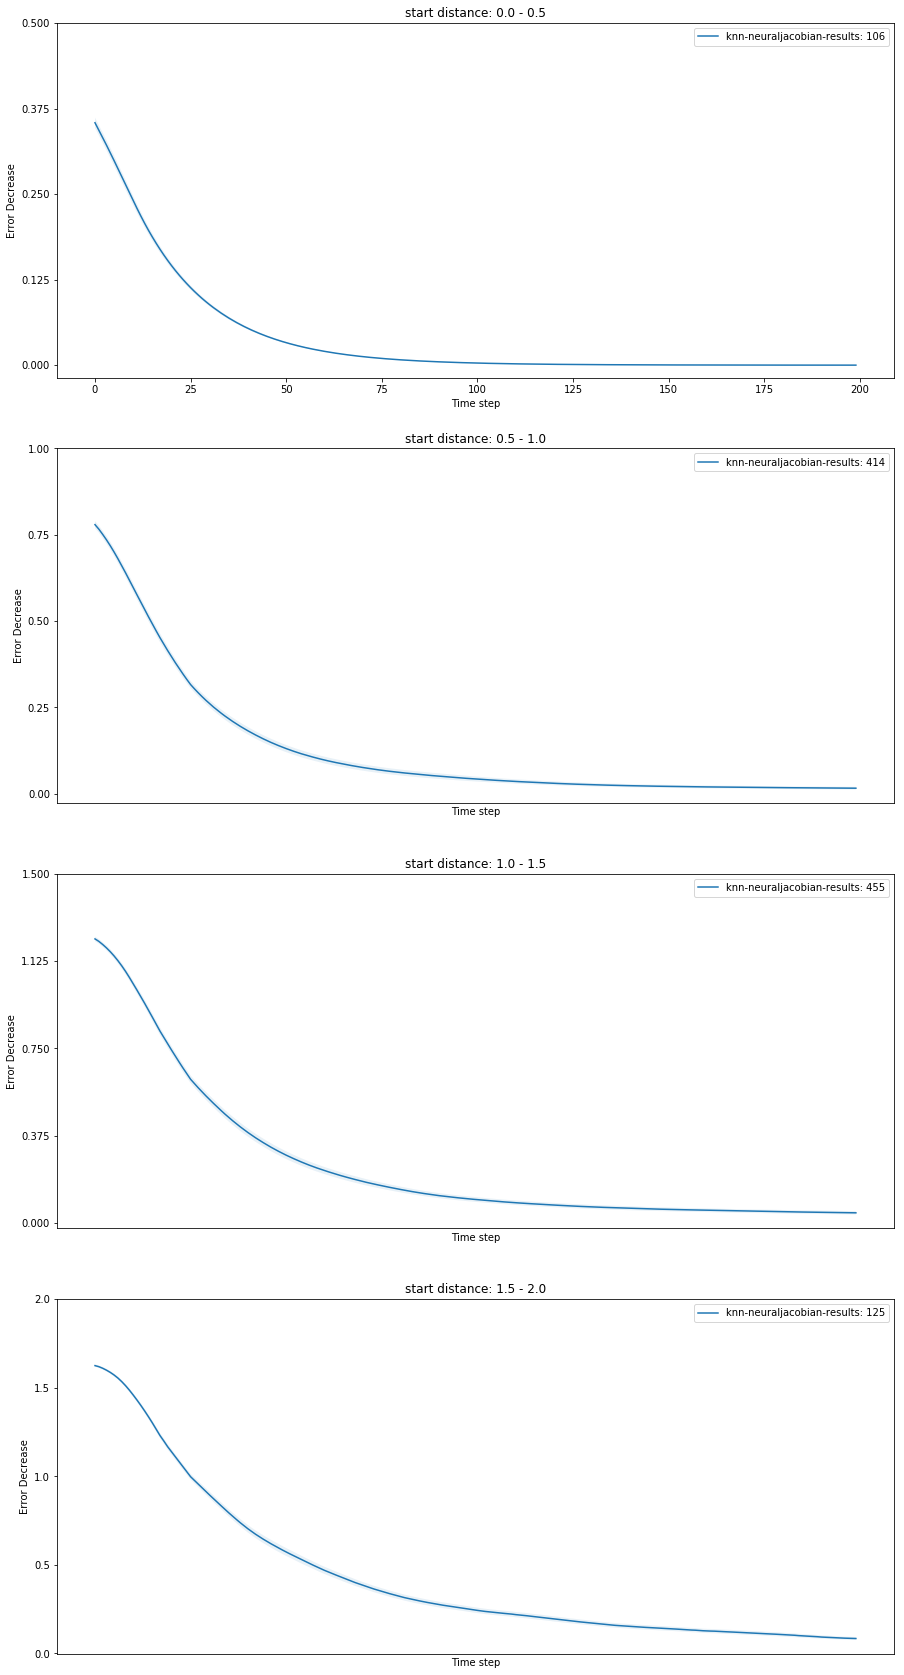

In [6]:

err_curr_res = {}
for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1)
    err_curr_res[algorithm] = err_over_time
    plot_mu_sig(err_over_time, label=algorithm, ax=ax)
    
bounds = [0.0, 0.5, 1.0, 1.5, 2.0]
fig, axs = plt.subplots(len(bounds) - 1, 1, figsize=(15, 30))
i = 0
for start, end in zip(bounds[:-1], bounds[1:]):
    ax = axs[i]
    for algorithm in results.keys():
        err_over_time = err_curr_res[algorithm]
        to_plot = np.logical_and(err_over_time[0, :] >= start, err_over_time[0, :] < end)
        plot_mu_sig(err_over_time[:, to_plot], label=algorithm +": {}".format(to_plot.sum()), ax=ax)
    
    
    ax.get_yaxis().set_ticks(np.linspace(0.0, end, 5))
    ax.legend()
    ax.set_title("start distance: {} - {}".format(start, end))
    if i == len(results) - 1:
        ax.set_xlabel("start mean squared error")
    else:
        ax.get_xaxis().set_ticks([])
    ax.set_xlabel("Time step")
    
    ax.set_ylabel("Error Decrease")
    i += 1

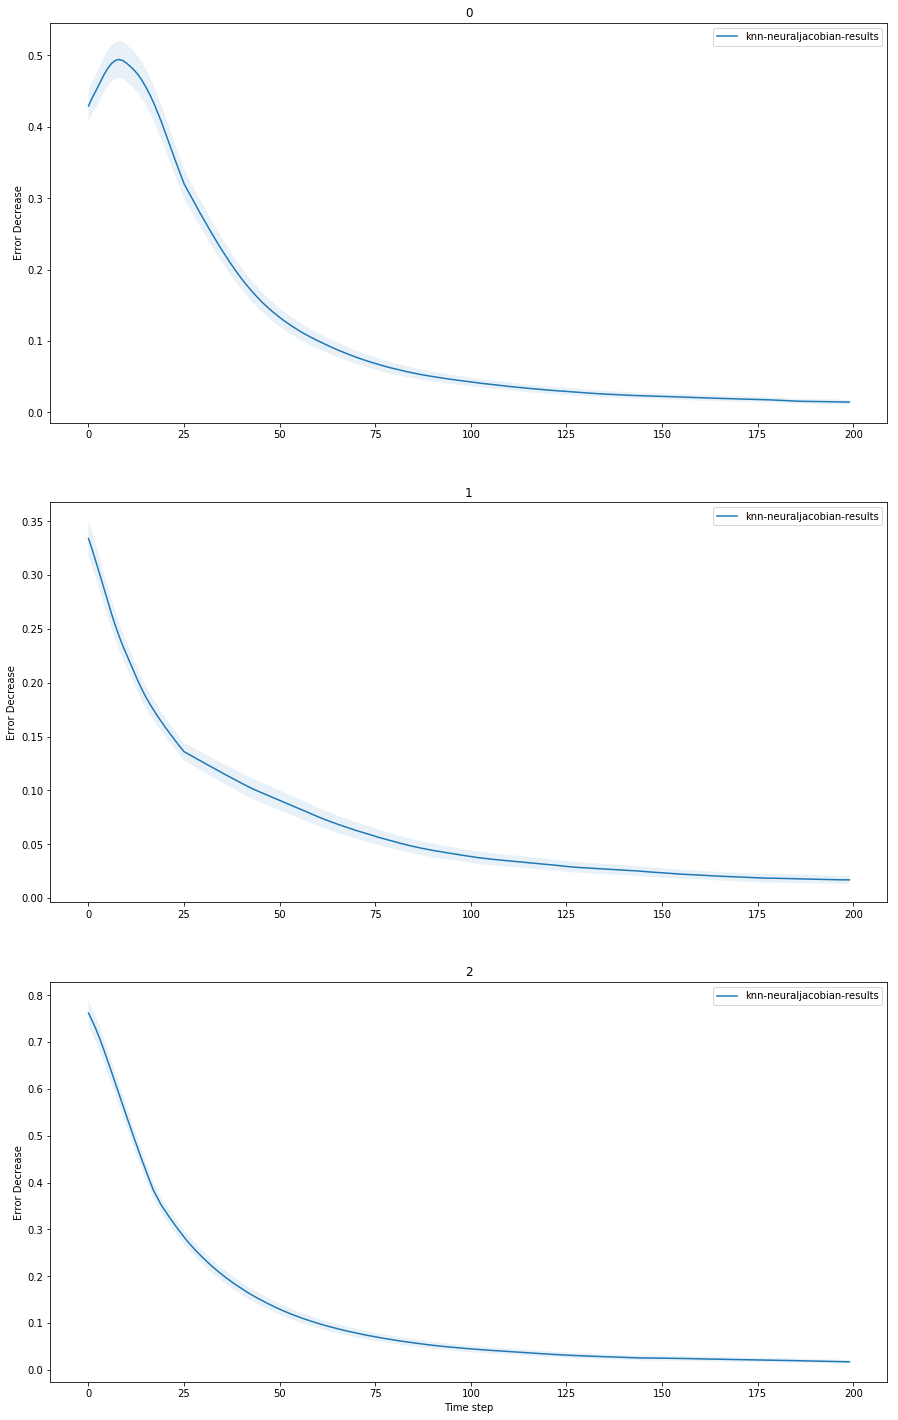

In [7]:
titles = [str(i) for i in range(3)]
fig, axs = plt.subplots(len(titles), 1, figsize=(15, 25))
for i, ax in enumerate(axs):
    for algorithm, result in results.items():
        err_over_time = collect_eps_errs(result, dim=i)
        plot_mu_sig(err_over_time, label=algorithm, ax=ax)
        ax.set_title(titles[i])
        ax.legend()
        if i == 2:
            ax.set_xlabel("Time step")
        ax.set_ylabel("Error Decrease")

# Visualising start and end points for Trajectories

In this section we visualize the starting position against the end position. The intention of these plots is to understand how distance to the target might affect convergence

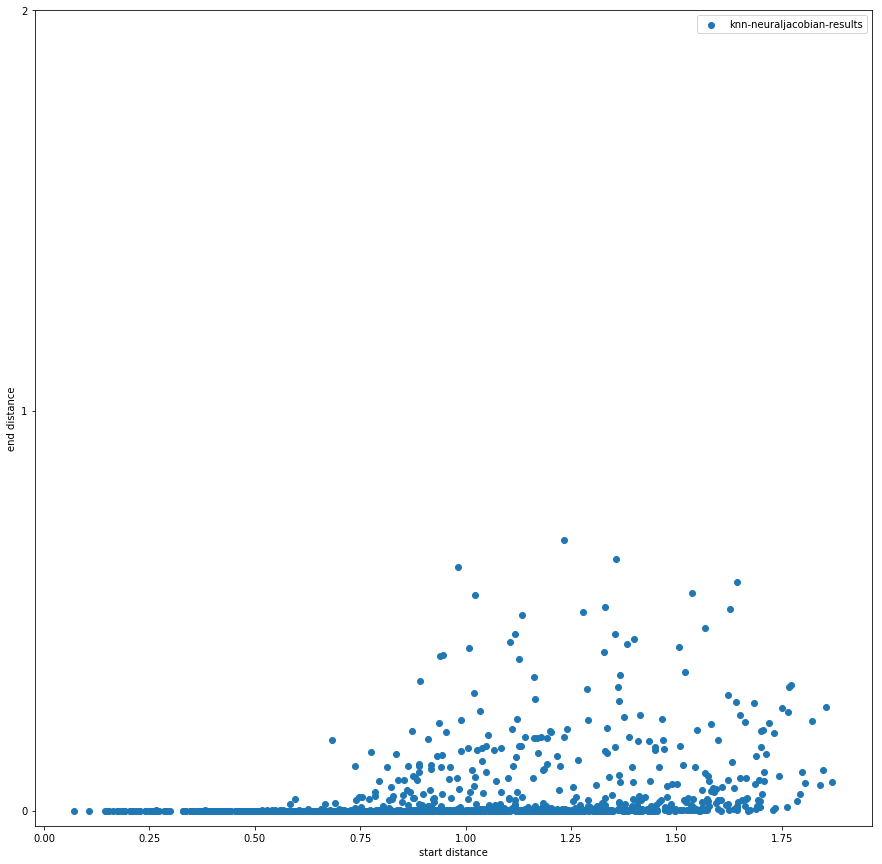

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1)
    
    start = err_over_time[0,:]
    end = err_over_time[-1,:]
    ax.scatter(start, end, label=algorithm)
    i += 1
    #ax.set_title(algorithm)
    ax.legend()
    ax.get_yaxis().set_ticks([0.0, 1.0,  2.0])
    ax.set_xlabel("start distance")
    ax.set_ylabel("end distance")

TypeError: 'AxesSubplot' object does not support indexing

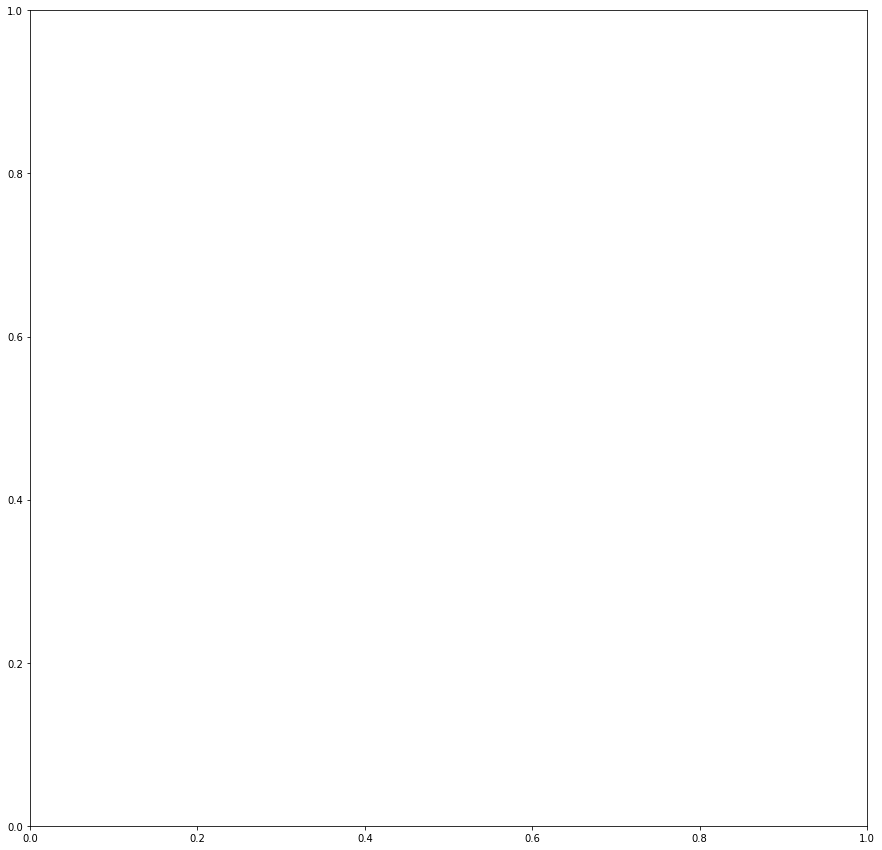

In [9]:


fig, axs = plt.subplots(len(results), 1, figsize=(15, 15))
i = 0
for algorithm, result in results.items():
    ax = axs[i]
    err_over_time = collect_eps_errs(result, dim=-1)
    
    start = err_over_time[0,:]
    end = err_over_time[-1,:]
    ax.scatter(start, end, label=algorithm)
    i += 1
    #ax.set_title(algorithm)
    ax.legend()
    ax.get_yaxis().set_ticks([float(i)*0.1 for i in range(0, 20, 4)])
    if i == len(results):
        ax.set_xlabel("start mean squared error")
    else:
        ax.get_xaxis().set_ticks([])
    ax.set_ylabel("end mean squared error")

# Violin Plots of Area under the Curve

In this section we summarise the above error plots by looking at the AUC for each trajectory. Smaller AUC score are indicative of faster convergence to the target. This also gives us way to compare different algorithms a bit more 

(1100,)


Text(0.5, 1.0, 'AUC of Trajectories for Different UVS Algorithms')

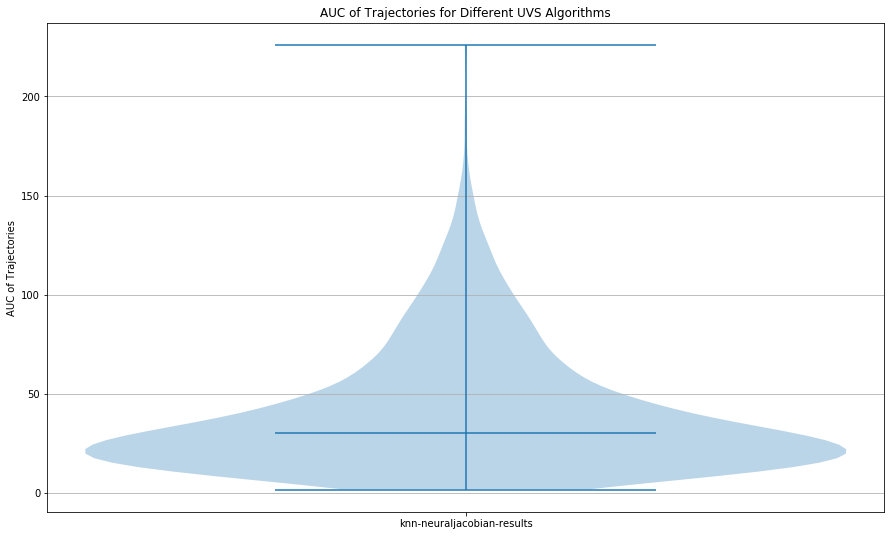

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))

labels = []
aucs = []
for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1)
    #Here, we WANT to sum over each run
    #above we do not because that is less meaninful
    auc = err_over_time.sum(axis=0)   # for delta t between each timestep
    print(auc.shape)
    aucs.append(auc)
    labels.append(algorithm)
    
ax.violinplot(aucs, showmeans=False, showmedians=True)
ax.set_xticks(np.arange(1, len(labels) + 1))
ax.set_xticklabels(labels)
ax.yaxis.grid(True)
ax.set_ylabel("AUC of Trajectories")
ax.set_title("AUC of Trajectories for Different UVS Algorithms")

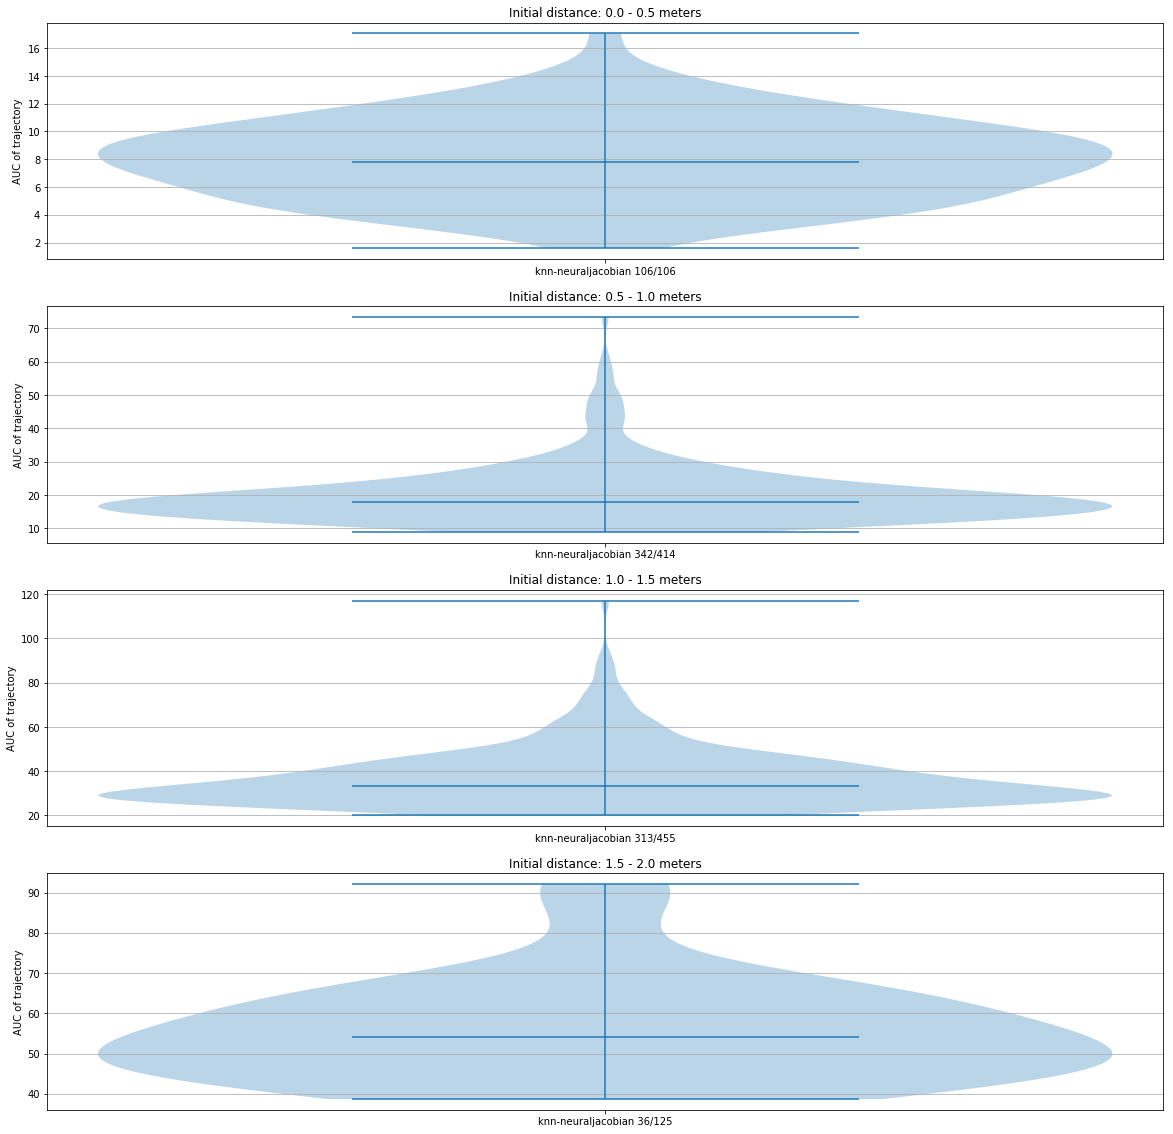

In [11]:
fig, axs = plt.subplots(4, 1, figsize=(20, 20))

bounds = [0.0, 0.5, 1.0, 1.5, 2.0]
i = 0
violin_results = {}
for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1)
    violin_results[algorithm] = err_over_time
    
successTable = {}
for low, high in zip(bounds[:-1], bounds[1:]):
    labels = []
    aucs = []
    count = []
    for algorithm, result in violin_results.items():
        err_over_time = result#collect_eps_errs(result, dim=-1)
        #Here, we WANT to sum over each run
        #above we do not because that is less meaninful
        
        to_plot = np.logical_and(err_over_time[0, :] >= low, err_over_time[0, :] < high)
        count.append(to_plot.sum())
        
        to_plot = np.logical_and(to_plot, err_over_time[-1,:] <= .005)
        
        percentage = to_plot.sum() / count[-1]
        auc = err_over_time.sum(axis=0)   # for delta t between each timestep
        auc = auc[to_plot]
        if len(auc) == 0:
            auc = np.zeros(err_over_time.shape[-1])
        #print(auc.shape, low, high, to_plot.sum())
        algorithm = algorithm.split('-results')[0]
        
        if not algorithm in successTable:
            successTable[algorithm] = {"{}-{}".format(low,high): percentage}
        else:
            successTable[algorithm]["{}-{}".format(low,high)] = percentage
            
        aucs.append(auc)
        if "global-neuralnetwork" in algorithm:
            labels.append(algorithm.split("global-")[-1])
        else:
            labels.append(algorithm)
    ax = axs[i]
    i+= 1
    ax.violinplot(aucs, showmeans=False, showmedians=True)
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels([l + " {}/{}".format(len(a),c) for l, a, c in zip(labels, aucs,count)])
    ax.yaxis.grid(True)
    ax.set_ylabel("AUC of trajectory")
    ax.set_title("Initial distance: {} - {} meters".format(low, high))
    

# These are just tables of statistics from the trajectories 
The basic question is whether or not they reached the target. 
We considered the target reached by some threshold


In [12]:
successTable = {}
for low, high in zip(bounds[:-1], bounds[1:]):
    labels = []
    aucs = []
    count = []
    for algorithm, result in violin_results.items():
        err_over_time = result#collect_eps_errs(result, dim=-1)
        #Here, we WANT to sum over each run
        #above we do not because that is less meaninful
        
        to_plot = np.logical_and(err_over_time[0, :] >= low, err_over_time[0, :] < high)
        count.append(to_plot.sum())
        
        to_plot = np.logical_and(to_plot, err_over_time[-1,:] <= .005)
        
        percentage = to_plot.sum() / count[-1] * 100.0 #so it's between 0 - 100%
        algorithm = algorithm.split('-results')[0]
        if "global-" in algorithm:
            algorithm = algorithm.split('global-')[-1]
        
        if not algorithm in successTable:
            successTable[algorithm] = {"{}m - {}m".format(low,high): percentage}
        else:
            successTable[algorithm]["{}m - {}m".format(low,high)] = percentage
            
        if "global-neuralnetwork" in algorithm:
            labels.append(algorithm.split("global-")[-1])
        else:
            labels.append(algorithm)
    
for algorithm, result in violin_results.items():
    err_over_time = result
    succeses = (err_over_time[-1,:] <= .005)
    percentage = succeses.sum() / err_over_time.shape[1] * 100.0 #so it's between 0 - 100%
    algorithm = algorithm.split('-results')[0]
    if "global-" in algorithm:
        algorithm = algorithm.split('global-')[-1]
    if not algorithm in successTable:
            successTable[algorithm] = {"Overall": percentage}
    else:
        successTable[algorithm]["Overall"] = percentage
    
successTable = pd.DataFrame.from_dict(successTable).round(2).transpose()
successTable

,0.0m - 0.5m,0.5m - 1.0m,1.0m - 1.5m,1.5m - 2.0m,Overall
knn-neuraljacobian,100.0,82.61,68.79,28.8,72.45


['0.0m - 0.5m', '0.5m - 1.0m', '1.0m - 1.5m', '1.5m - 2.0m', 'Overall']
[100.0, 82.61, 68.79, 28.8, 72.45]
['0.0m - 0.5m', '0.5m - 1.0m', '1.0m - 1.5m', '1.5m - 2.0m', 'Overall']


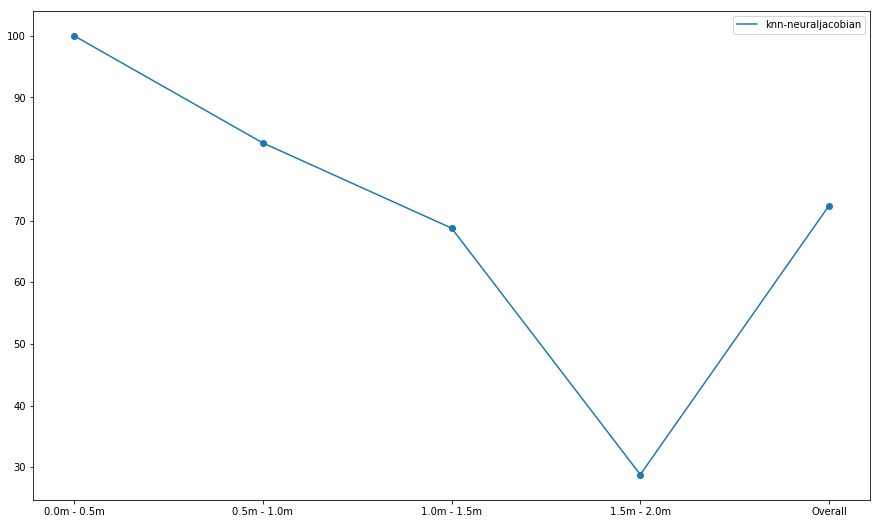

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
cols = successTable.columns.values
rows = successTable.index.values
print(cols.tolist())
for r in rows:
    row = successTable.loc[r].tolist()
    print(row)
    #ax.step(np.arange(len(row)), row,  where='post', label = r)
    ax.plot(row, label =r)
    ax.scatter(np.arange(len(row)), row)
ax.legend()
ax.set_xticks(np.arange(len(row)))
ax.set_xticklabels(cols.tolist())
print(cols.tolist())

In [14]:
end_dist_table = {}
end_dist_table_std = {}
for low, high in zip(bounds[:-1], bounds[1:]):
    labels = []
    aucs = []
    count = []
    for algorithm, result in violin_results.items():
        err_over_time = result#collect_eps_errs(result, dim=-1)
        #Here, we WANT to sum over each run
        #above we do not because that is less meaninful
        
        to_plot = np.logical_and(err_over_time[0, :] >= low, err_over_time[0, :] < high)
        end_diff = err_over_time[-1,:]
        end_diff = end_diff[to_plot]
        
        
        mu = end_diff.mean()
        std = end_diff.std() / np.sqrt(np.sum(to_plot))
        algorithm = algorithm.split('-results')[0]
        if "global-" in algorithm:
            algorithm = algorithm.split('global-')[-1]
        
        if not algorithm in end_dist_table:
            end_dist_table[algorithm] = {"{}m - {}m".format(low,high): mu}
            end_dist_table_std[algorithm] = {"{}m - {}m".format(low,high): std}
        else:
            end_dist_table[algorithm]["{}m - {}m".format(low,high)] = mu
            end_dist_table_std[algorithm]["{}m - {}m".format(low,high)] = std
            
        if "global-neuralnetwork" in algorithm:
            labels.append(algorithm.split("global-")[-1])
        else:
            labels.append(algorithm)
    
for algorithm, result in violin_results.items():
    err_over_time = result
    end_diff = err_over_time[-1,:]
    mu = end_diff.mean()
    std = end_diff.std()  / np.sqrt(np.sum(to_plot)) #ste
    
    algorithm = algorithm.split('-results')[0]
    if "global-" in algorithm:
        algorithm = algorithm.split('global-')[-1]
    if not algorithm in end_dist_table:
            end_dist_table[algorithm] = {"Overall": mu}
            end_dist_table_std[algorithm] = {"Overall".format(low,high): std}
    else:
        end_dist_table[algorithm]["Overall"] = mu
        end_dist_table_std[algorithm]["Overall"] = std
        
    
end_dist_table = pd.DataFrame.from_dict(end_dist_table).round(3).transpose()
end_dist_table_std = pd.DataFrame.from_dict(end_dist_table_std).round(3).transpose()
end_dist_table

,0.0m - 0.5m,0.5m - 1.0m,1.0m - 1.5m,1.5m - 2.0m,Overall
knn-neuraljacobian,0.0,0.016,0.043,0.085,0.033


['0.0m - 0.5m', '0.5m - 1.0m', '1.0m - 1.5m', '1.5m - 2.0m', 'Overall']
['0.0m - 0.5m', '0.5m - 1.0m', '1.0m - 1.5m', '1.5m - 2.0m', 'Overall']


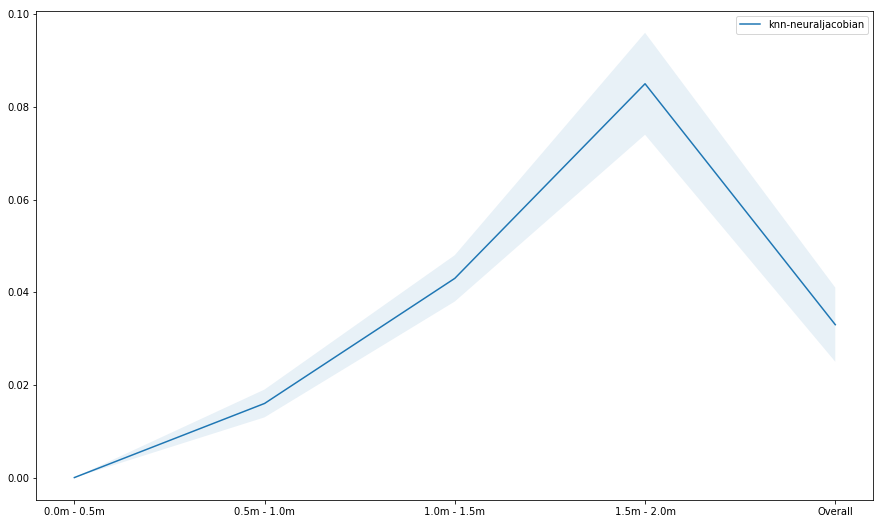

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
cols = end_dist_table.columns.values
rows = end_dist_table.index.values
print(cols.tolist())
for r in rows:
    row = np.array(end_dist_table.loc[r].tolist())
    std = np.array(end_dist_table_std.loc[r].tolist())
    ax.plot(row, label = r)
    ax.fill_between(list(range(len(row))), row + std, row - std, alpha=0.1)
ax.legend()
ax.set_xticks(np.arange(len(row)))
ax.set_xticklabels(cols.tolist())
print(cols.tolist())

Text(0.5, 1.0, 'AUC of Trajectories for Different UVS Algorithms')

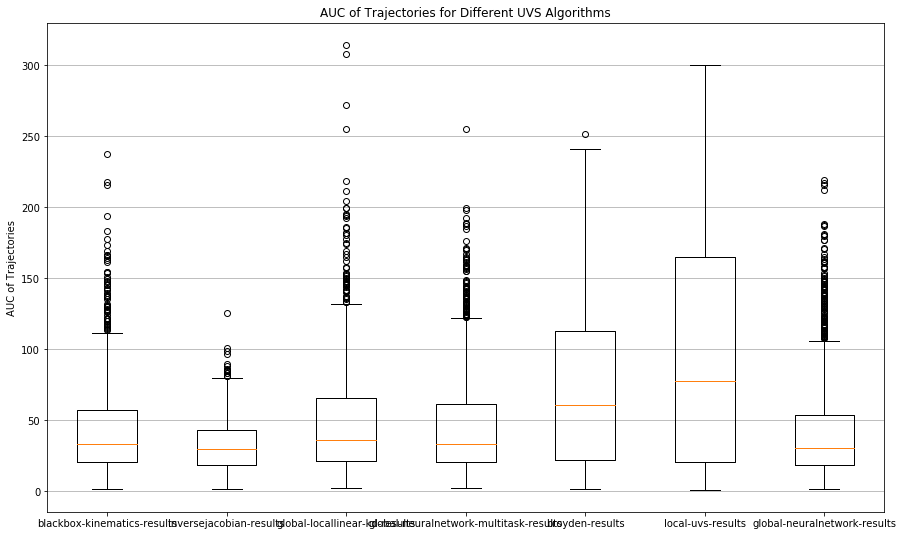

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))

labels = []
aucs = []
for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1) 
    #want to sum over each trajectory
    auc = err_over_time.sum(axis=0)  #for delta t between each time step
    aucs.append(auc)
    labels.append(algorithm)
    
ax.boxplot(aucs, labels=labels)

ax.yaxis.grid(True)
ax.set_ylabel("AUC of Trajectories")
ax.set_title("AUC of Trajectories for Different UVS Algorithms")

# Comparing Jacobians

Here, we just calaculate the difference between Jacobians in trajectories to see how much they differ from the true underlying Jacobian

In [16]:
def collect_jacobian_dist(result, norm=None):
    err_over_time = []
    for k, value in result.items():
        episode_err = []
        for v in value:
            estimate_J = v[-2] 

            true_J = v[-1]
            if norm is not "signs":
                mse = np.linalg.norm(estimate_J - true_J, norm) #, 'fro')
            else:
                sign_mismatch = np.logical_not(np.logical_and(estimate_J, true_J))
                mse = (sign_mismatch).sum() #techinically not mind you...
            episode_err.append(mse)
        err_over_time.append(episode_err)    
    
    return np.array(err_over_time).T

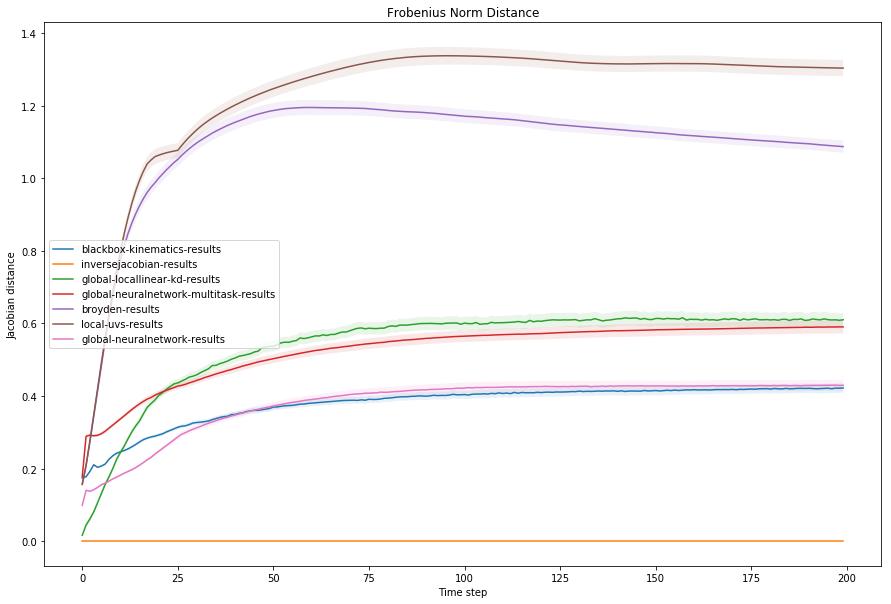

In [32]:
#Focusing only on the frobenius norm
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

for algorithm, result in results.items():
    jac_err = collect_jacobian_dist(result)

    plot_mu_sig(jac_err, label=algorithm, axis=1, ax=ax)
    
ax.set_xlabel('Time step')
ax.set_ylabel('Jacobian distance')
ax.set_title("Frobenius Norm Distance")
ax.legend()


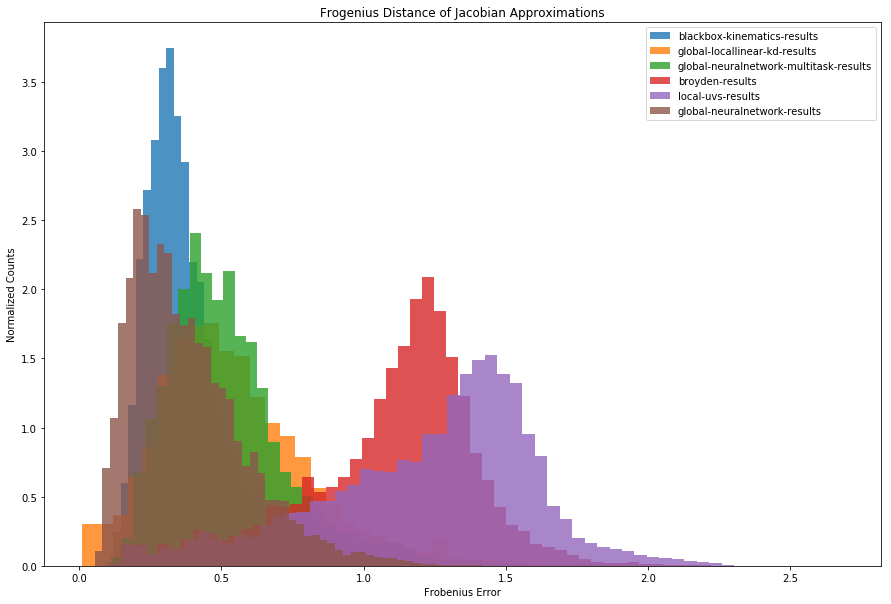

In [18]:
#Focusing only on the frobenius norm
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

for algorithm, result in results.items():
    if "inverse" in algorithm:
        continue
    jac_err = collect_jacobian_dist(result)
    jac_err = jac_err.flatten()

    ax.hist(jac_err, bins=50, alpha=0.8, density=True, label=algorithm)
    
ax.set_xlabel('Frobenius Error')
ax.set_ylabel('Normalized Counts')
ax.set_title("Frogenius Distance of Jacobian Approximations")
ax.legend()

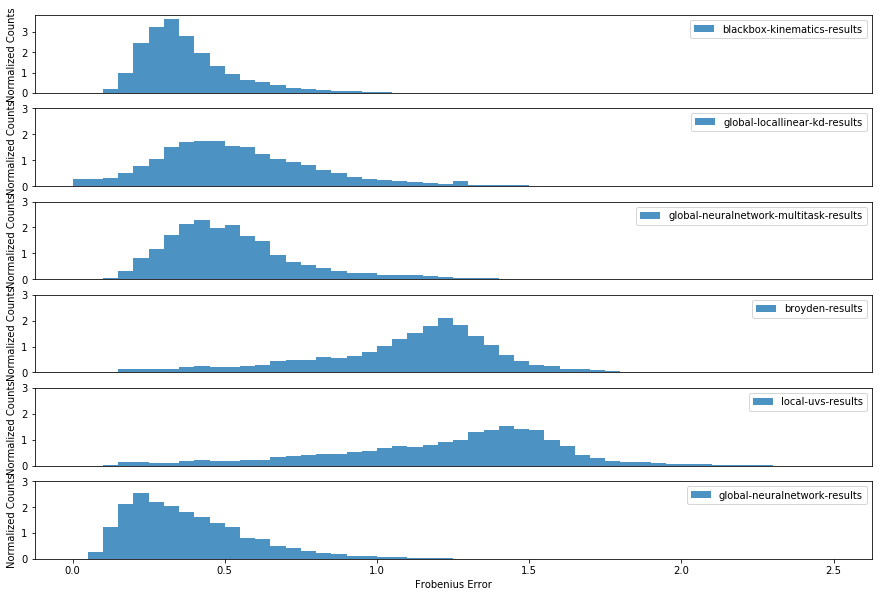

In [19]:
#Focusing only on the frobenius norm
fig, axs = plt.subplots(len(results) - 1, 1, figsize=(15, 10))
i = 0
for algorithm, result in results.items():
    if "inverse" in algorithm:
        continue
    ax = axs[i]
    i += 1
    jac_err = collect_jacobian_dist(result)
    jac_err = jac_err.flatten()

    ax.hist(jac_err, bins=50, alpha=0.8, density=True, label=algorithm, range=(0, 2.5))
    
    ax.set_ylabel('Normalized Counts')
    ax.get_yaxis().set_ticks([float(i)*0.1 for i in range(0, 40, 10)])
    if i == 0:
        ax.set_title("Frobenius Distance of Jacobian Approximations")
    if i < len(results) - 1:
        ax.set_xticks([])
    if i == (len(results) - 1):
        ax.set_xlabel('Frobenius Error')
        
        
    ax.legend()

In [20]:
#collects results for plotting histograms and trajectories
err_curr_res = {}
jac_errs = {}
for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1)
    err_curr_res[algorithm] = err_over_time
    jac_err = collect_jacobian_dist(result)
    jac_errs[algorithm] = jac_err

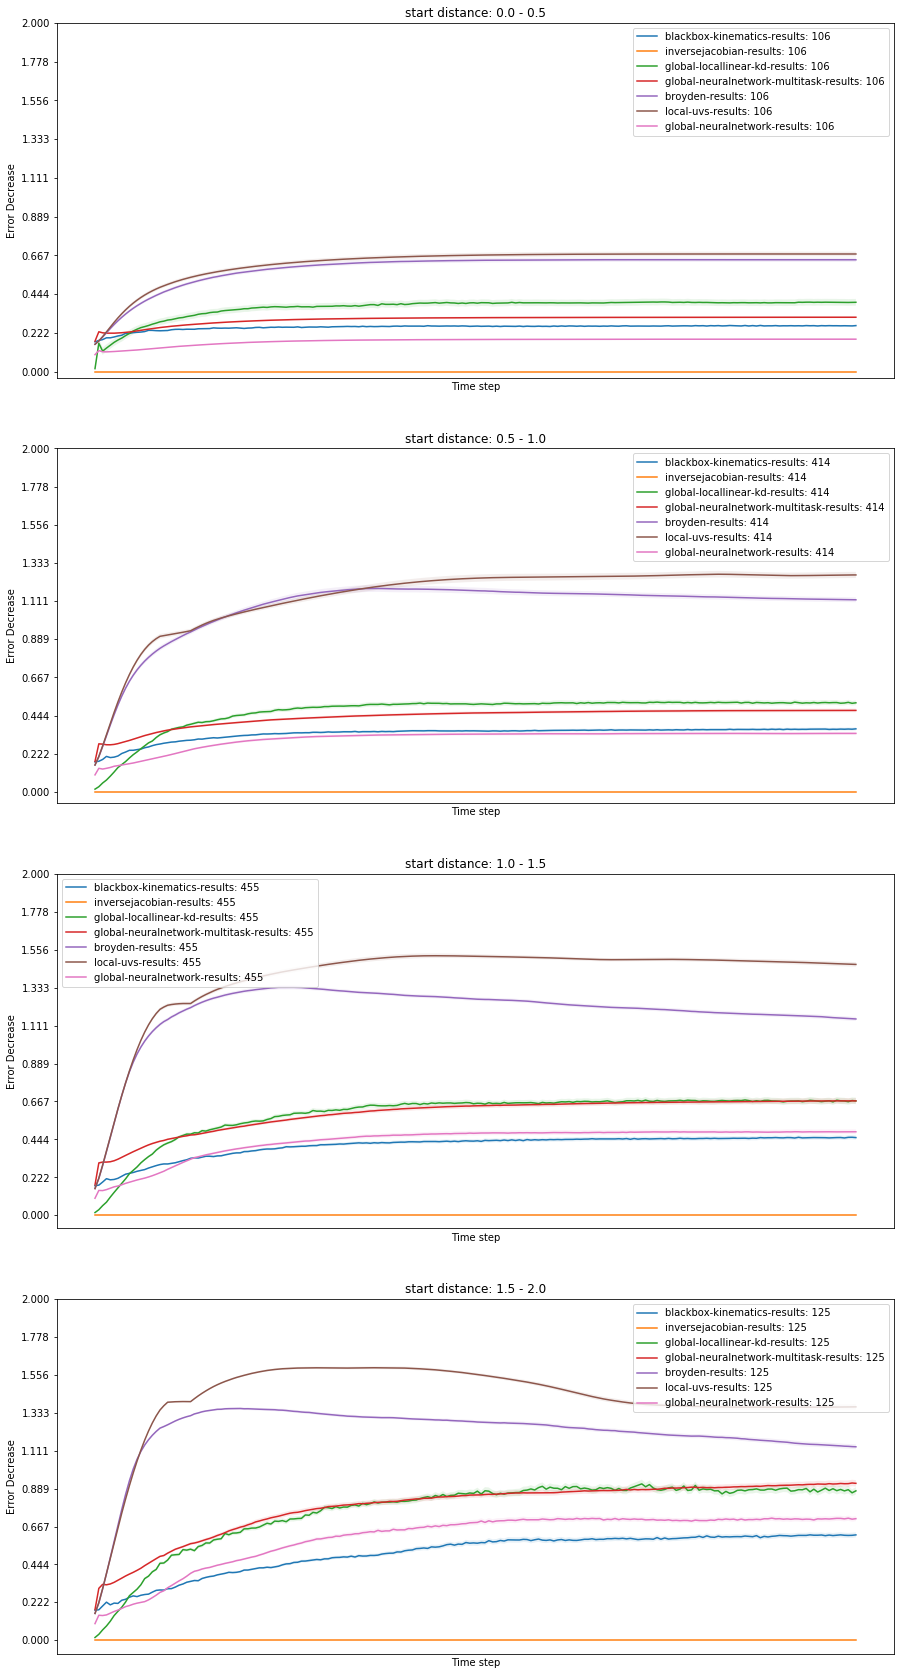

In [33]:

bounds = [0.0, 0.5, 1.0, 1.5, 2.0]
fig, axs = plt.subplots(len(bounds) - 1, 1, figsize=(15, 30))
i = 0
for start, end in zip(bounds[:-1], bounds[1:]):
    ax = axs[i]
    for algorithm in results.keys():
        err_over_time = err_curr_res[algorithm]
        to_plot = np.logical_and(err_over_time[0, :] >= start, err_over_time[0, :] < end)
        plot_mu_sig(jac_errs[algorithm][:,to_plot], label=algorithm +": {}".format(to_plot.sum()), ax=ax)
        
    
    
    ax.get_yaxis().set_ticks(np.linspace(0.0, 2.0, 10))
    ax.legend()
    ax.set_title("start distance: {} - {}".format(start, end))
    if i == len(results):
        ax.set_xlabel("start mean squared error")
    else:
        ax.get_xaxis().set_ticks([])
    ax.set_xlabel("Time step")
    
    ax.set_ylabel("Error Decrease")
    i += 1

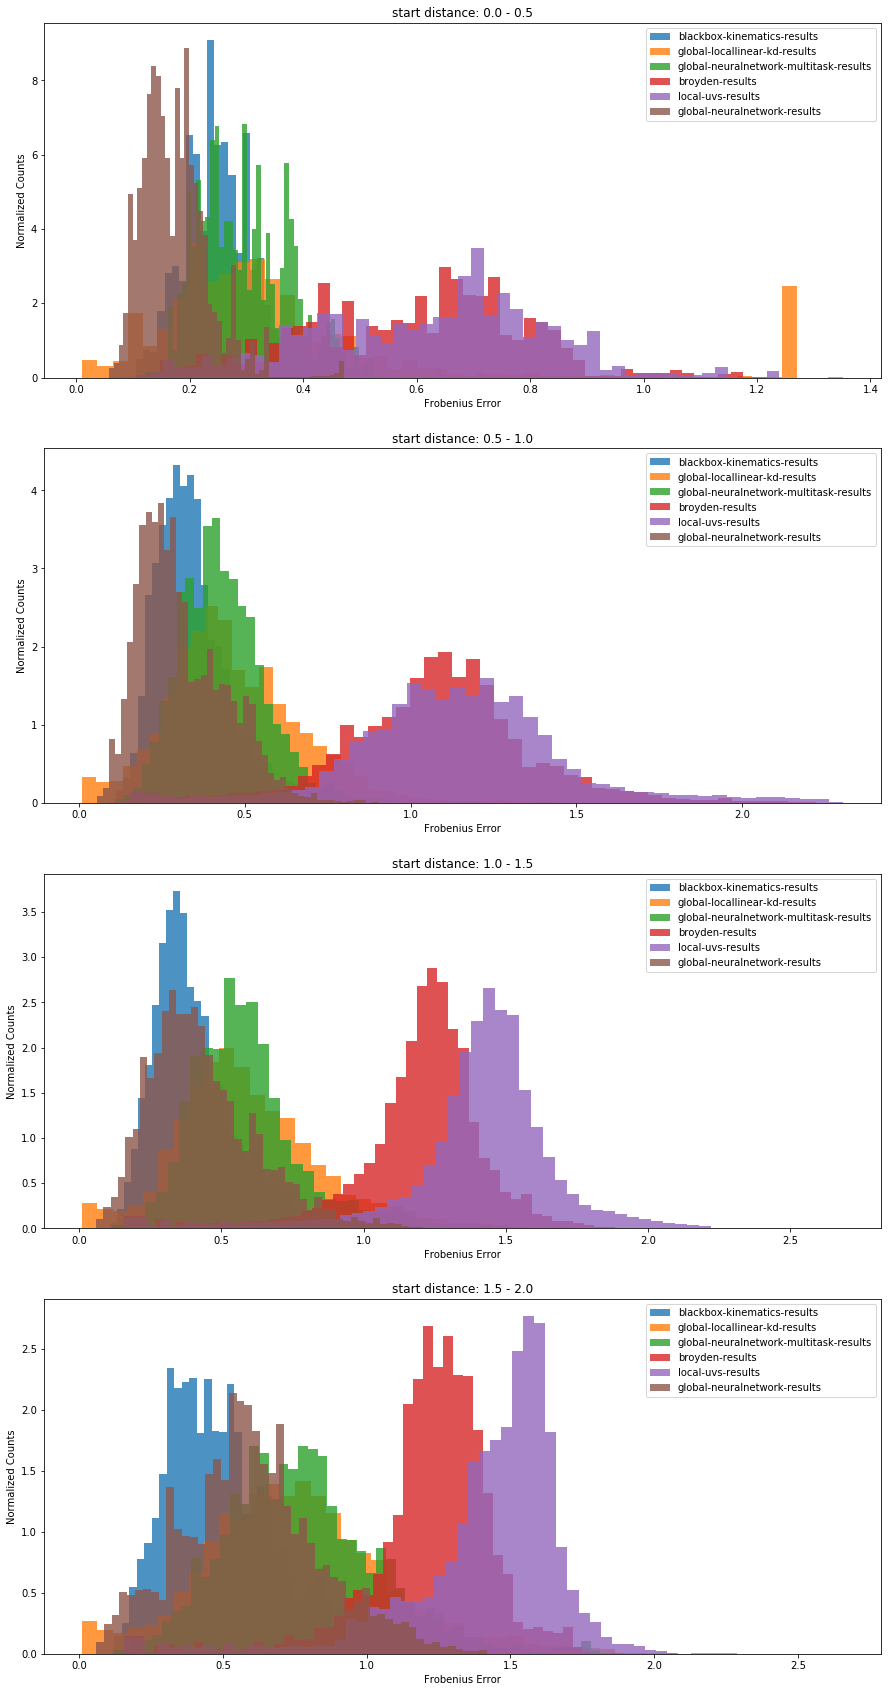

In [22]:


bounds = [0.0, 0.5, 1.0, 1.5, 2.0]
fig, axs = plt.subplots(len(bounds) - 1, 1, figsize=(15, 30))
i = 0
for start, end in zip(bounds[:-1], bounds[1:]):
    ax = axs[i]
    for algorithm in results.keys():
        if "inverse" in algorithm:
            continue
        err_over_time = err_curr_res[algorithm]
        to_plot = np.logical_and(err_over_time[0, :] >= start, err_over_time[0, :] < end)
        jac_err = jac_errs[algorithm][:,to_plot]
        jac_err = jac_err.flatten()
        ax.hist(jac_err, bins=50, alpha=0.8, density=True, label=algorithm)
    
    ax.legend()
    ax.set_title("start distance: {} - {}".format(start, end))
    ax.set_xlabel("Frobenius Error")
    
    ax.set_ylabel("Normalized Counts")
    i += 1

In [23]:
jac_err.shape

(25000,)

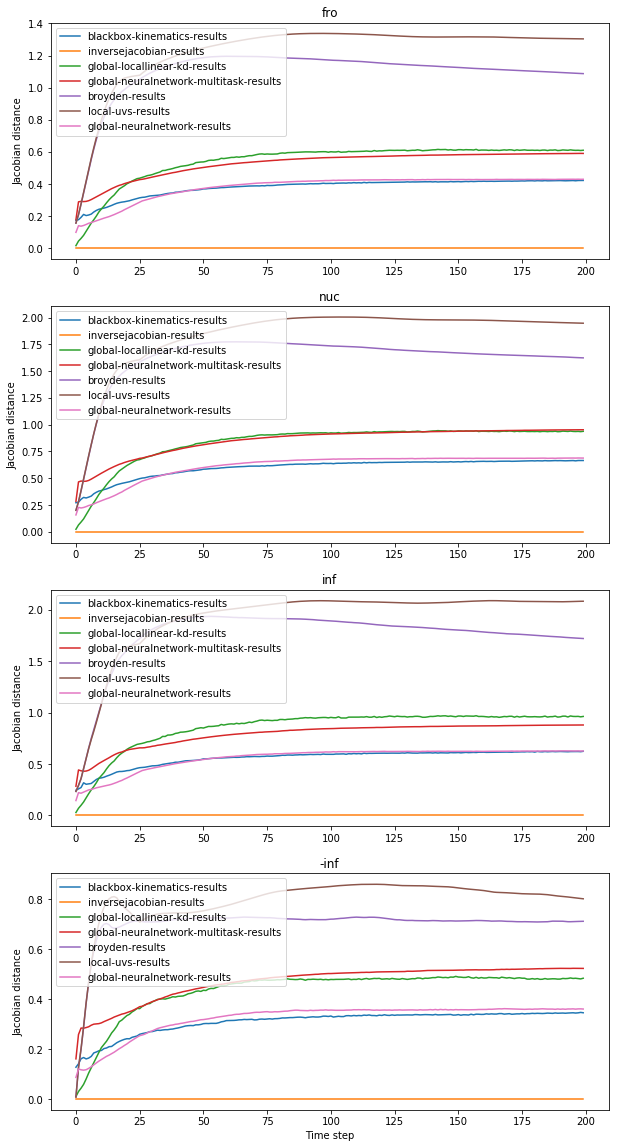

In [24]:
#Seeing if differen't norms highlight any othernotable differences
fig, axs = plt.subplots(4, 1, figsize=(10, 20))
norms = ['fro', 'nuc', np.inf, -np.inf]
for i, ax in enumerate(axs):
    n = norms[i]
    for algorithm, result in results.items():
        jac_err = collect_jacobian_dist(result, norm=n)
        plot_mu_sig(jac_err, label=algorithm, axis=1, ax=ax)
    if i == 3:
        ax.set_xlabel('Time step')
    ax.set_ylabel('Jacobian distance')
    ax.set_title(n)
    ax.legend()

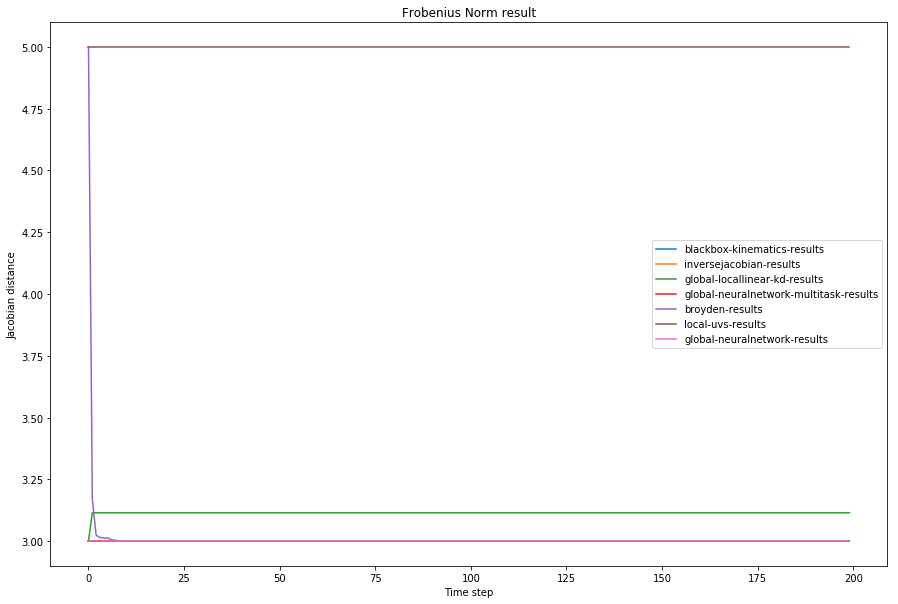

In [25]:
#Focusing only on the sign  norm
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

for algorithm, result in results.items():
    jac_err = collect_jacobian_dist(result, norm='signs')
    plot_mu_sig(jac_err, label=algorithm, axis=1, ax=ax)
    
ax.set_xlabel('Time step')
ax.set_ylabel('Jacobian distance')
ax.set_title("Frobenius Norm result")
ax.legend()

# On the rank of our Jacobian
In these plots we're mostly interested in seeing whether or not our Jacobian's are full rank or not. 
We also consider the ratio of the maximum to minimum singular values of the jacobian to see if we are in singularity configurations

In [25]:
def check_jacobian_dexterity(result):
    #we use 3rd dexterity definition in : 
    #https://vtechworks.lib.vt.edu/bitstream/handle/10919/30363/Chap4.pdf?sequence=7&isAllowed=y
    #this is just ratio of largest to smallest singular values 
    err_over_time = []
    for k, value in result.items():
        episode_err = []
        for v in value:
            #Check against true jacobian
            #If our approximation is good, presumably the matrix should still be positive definite
            # i.e. the approximate J is transferable 
            J_hat = v[-2] 
            J = v[-1]
            n, m = J_hat.shape
            smaller_dims = min(n, m)
            _, s, _ = np.linalg.svd(J_hat, full_matrices=False, compute_uv=True, hermitian=False)
            s = s[:smaller_dims] #to determine if full rank on smaller dimension...i.e. the rows for me
            loss = max(s) / min(s)
            #loss = np.all((s > 0)) #if all greater than 0 implies fu
            episode_err.append(loss)
        err_over_time.append(episode_err)    
    
    return np.array(err_over_time).T

def check_jacobian_rank(result):
    #we use 3rd dexterity definition in : 
    #https://vtechworks.lib.vt.edu/bitstream/handle/10919/30363/Chap4.pdf?sequence=7&isAllowed=y
    #this is just ratio of largest to smallest singular values 
    err_over_time = []
    for k, value in result.items():
        episode_err = []
        for v in value:
            #Check against true jacobian
            #If our approximation is good, presumably the matrix should still be positive definite
            # i.e. the approximate J is transferable 
            J_hat = v[-2] 
            J = v[-1]
            n, m = J_hat.shape
            smaller_dims = min(n, m)
            _, s, _ = np.linalg.svd(J_hat, full_matrices=False, compute_uv=True, hermitian=False)
            s = s[:smaller_dims] #to determine if full rank on smaller dimension...i.e. the rows for me
            loss = np.all((s > 0.1)) #if all greater than 0.1 not super close to a singularity
            episode_err.append(loss)
        err_over_time.append(episode_err)    
    
    return np.array(err_over_time).T

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/home/przystupa/.local/lib/python3.5/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/przystupa/.local/lib/python3.5/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


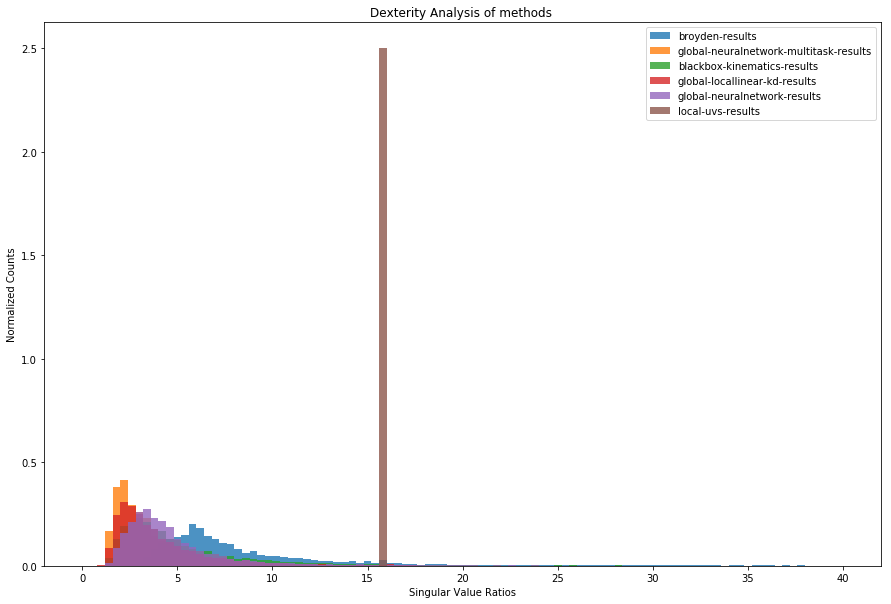

In [26]:
# look at the distribution of the singular value ratios for dexterity in workspace
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

for algorithm, result in results.items():
    if "inverse" in algorithm:
        continue
    singular_val_ratio = check_jacobian_dexterity(result)
    singular_val_ratio = singular_val_ratio.flatten()

    ax.hist(singular_val_ratio, bins=100, alpha=0.8, density=True, range=(0, 40), label=algorithm)
    
ax.set_xlabel('Singular Value Ratios')
ax.set_ylabel('Normalized Counts')
ax.set_title("Dexterity Analysis of methods ")
ax.legend()

In [1]:
#split trajectories by whether or not the matrix is full rank in rows (probably not)
fig, axs = plt.subplots(len(results.keys()), 1, figsize=(15, 20))
#if not isinstance(axs, list):
#    axs = [axs]
for i, k_v in enumerate(results.items()):
    algorithm, result = k_v[0], k_v[1]

    ax = axs[i]
    jac_err = check_jacobian_rank(result)
    
    #check if criteria is met for whole trajectory or not
    never_near_singularity = (jac_err.sum(axis=0) >=100) #singular values always above thresh
    pass_near_singularity = (jac_err.sum(axis=0) < 100) #at some poin
    
    err_over_time = collect_eps_errs(result, dim=-1)
    traj_pos_def = err_over_time[:,never_near_singularity]
    traj_not_pos_def = err_over_time[:, pass_near_singularity]
    
    
    total_traj = jac_err.shape[1]
    total_never_near_sing = never_near_singularity.sum()
    total_pass_near_singularity = pass_near_singularity.sum()
    
    #plot_mu_sig(err_over_time, label="All {} Trajectories".format(total_traj), ax=ax)
    plot_mu_sig(traj_pos_def, label="+ Not Near Singularity {} / {}".format(total_never_near_sing, total_traj), ax=ax)
    plot_mu_sig(traj_not_pos_def, label=" Near Singularity {}/{}".format(total_pass_near_singularity, total_traj), ax=ax)
    if i >= len(axs) - 1:
        ax.set_xlabel('Time step')
    ax.set_yticks(np.arange(0, 1.4, 0.2))
    ax.set_ylabel('MSE over time')
    ax.set_title("Positive Definite Criteria: {}".format(algorithm))
    ax.legend()

NameError: name 'plt' is not defined

# Checking for Criteria of Convergence
The last thing I want to check for is for whether or not the critieria on J is met for the trajectories. I will need to review this to make sure I understand it, but if JJ^{+} has any non-positive eigen values (0 or less) then hypothetically, it should not converge.

I think hypothetically JJ^{+} should be the identity matrix...and if it's not then we have problems otherwise, I'll need to read up on that. 

In [34]:
def check_pos_definite(A):
    eigs = np.linalg.eigvals(A)
            
    return (eigs > 0).all()
    
def check_jacobian_positive_definite(result, invert_true_J=False):
    err_over_time = []
    for k, value in result.items():
        episode_err = []
        for v in value:
            #Check against true jacobian
            #If our approximation is good, presumably the matrix should still be positive definite
            # i.e. the approximate J is transferable 
            J_hat = v[-2] 
            J = v[-1]
            
            if invert_true_J:
                iJ_hat = np.linalg.pinv(J_hat)
                JiJ = np.matmul(J, iJ_hat)
            else:
                iJ = np.linalg.pinv(J)
                JiJ = np.matmul(J_hat, iJ)
            is_pos_def = check_pos_definite(JiJ)
            loss = int(is_pos_def)
            episode_err.append(loss)
        err_over_time.append(episode_err)    
    
    return np.array(err_over_time).T


def check_jacobian_condition(result):
    conditioning_over_time = []
    true_solution_over_time = []
    for k, value in result.items():
        eps_conditioning = []
        true_conditioning = []
        for v in value:
            #Check against true jacobian
            #If our approximation is good, presumably the matrix should still be positive definite
            # i.e. the approximate J is transferable 
            #this was backwards.....
            J_hat = v[-1] 
            J = v[-2]
            
            #print("condition numbers:")
            #print("J hat", np.linalg.cond(J_hat), "J", np.linalg.cond(J), "JiJ", np.linalg.cond(JiJ))
            hat_cond = np.linalg.cond(J_hat)
            true_cond = np.linalg.cond(J)
            
            #iJ_hat = np.linalg.pinv(J_hat)
            #JiJ = np.matmul(J, iJ_hat)
            
            #JiJ_cond = np.linalg.cond(JiJ)
            eps_conditioning.append(hat_cond)
            true_conditioning.append(true_cond)
            
        conditioning_over_time.append(eps_conditioning)    
        true_solution_over_time.append(true_conditioning)
    return np.array(conditioning_over_time).T, np.array(true_solution_over_time).T




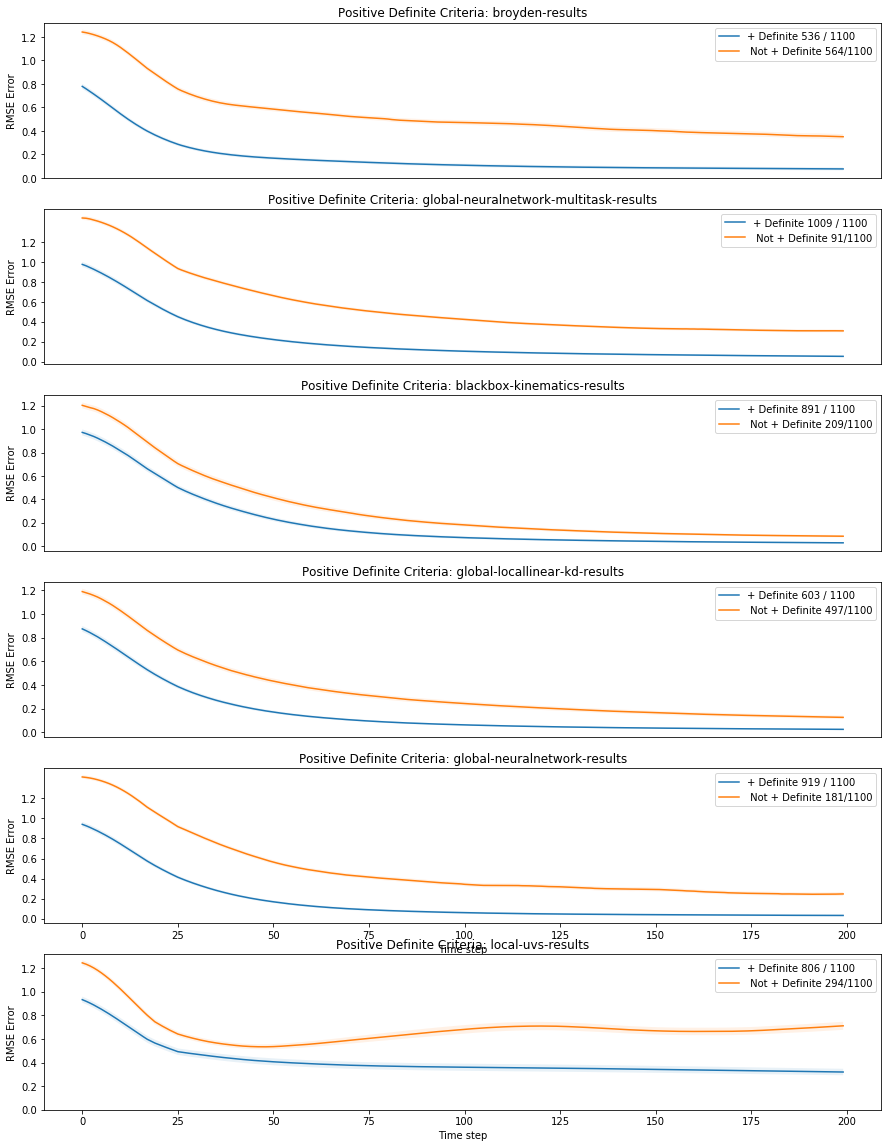

In [35]:
#Focusing only on the frobenius norm
fig, axs = plt.subplots(len(results.keys()) - 1 , 1, figsize=(15, 20))
#if not isinstance(axs, list):
#    axs = [axs]
i = 0
for k, v in results.items():
    algorithm, result = k, v
    if "inverse" in algorithm:
        continue
    ax = axs[i]
    i += 1
    jac_err = check_jacobian_positive_definite(result)
    
    #check if criteria is met for whole trajectory or not
    always_pos_def = (jac_err.sum(axis=0) >=200)
    not_always_pos_def = (jac_err.sum(axis=0) < 200)
    
    
    
    err_over_time = collect_eps_errs(result, dim=-1)
    traj_pos_def = err_over_time[:,always_pos_def]
    traj_not_pos_def = err_over_time[:, not_always_pos_def]
    
    
    total_traj = jac_err.shape[1]
    total_pos_d = always_pos_def.sum()
    total_not_pos_d = not_always_pos_def.sum()
    
    #plot_mu_sig(err_over_time, label="All {} Trajectories".format(total_traj), ax=ax)
    plot_mu_sig(traj_pos_def, label="+ Definite {} / {}".format(total_pos_d, total_traj), ax=ax)
    plot_mu_sig(traj_not_pos_def, label=" Not + Definite {}/{}".format(total_not_pos_d, total_traj), ax=ax)
    if i >= len(axs) - 1:
        ax.set_xlabel('Time step')
    else:
        ax.get_xaxis().set_ticks([])
    ax.set_yticks(np.arange(0, 1.4, 0.2))
    ax.set_ylabel('RMSE Error')
    ax.set_title("Positive Definite Criteria: {}".format(algorithm))
    ax.legend()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.
/home/przystupa/.local/lib/python3.5/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/przystupa/.local/lib/python3.5/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/przystupa/.local/lib/python3.5/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/przystupa/.local/lib/python3.5/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


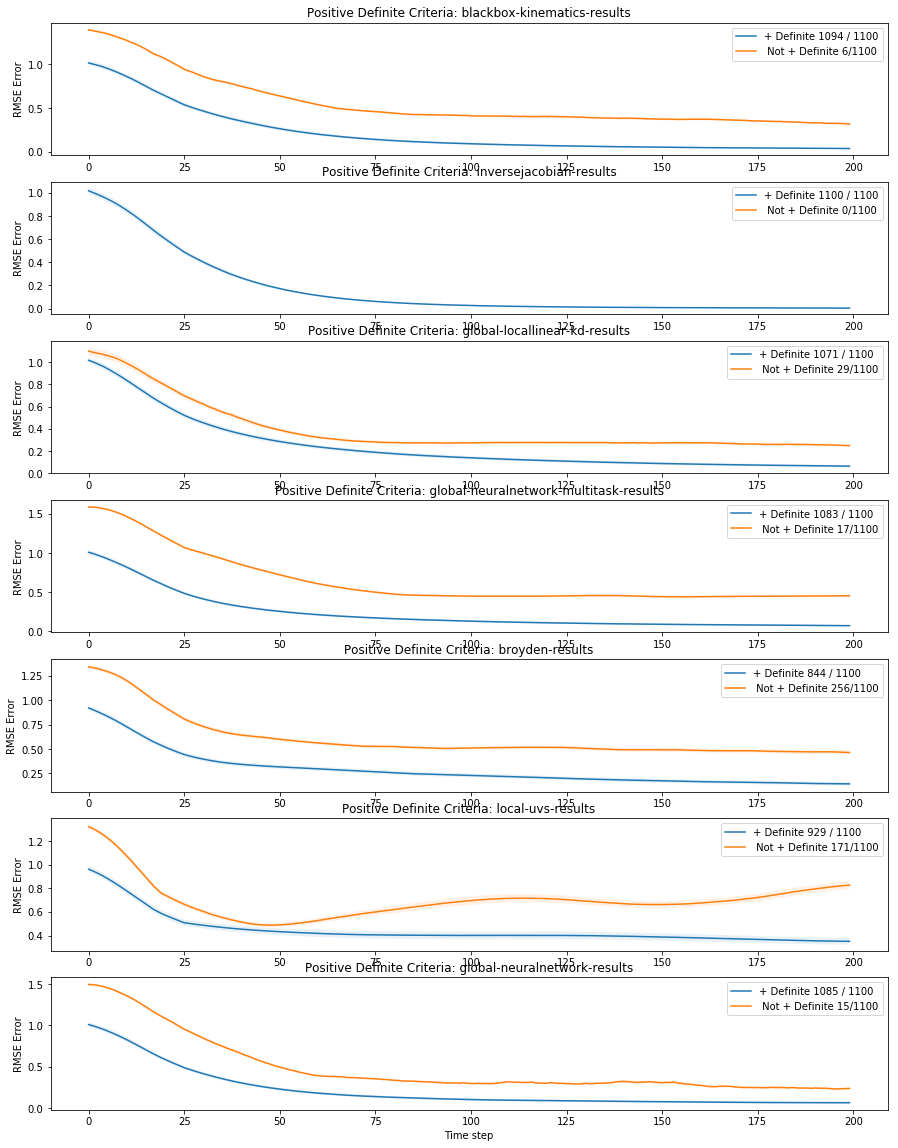

In [35]:
#Focusing only on the frobenius norm
fig, axs = plt.subplots(len(results.keys()), 1, figsize=(15, 20))
#if not isinstance(axs, list):
#    axs = [axs]
for i, k_v in enumerate(results.items()):
    algorithm, result = k_v[0], k_v[1]
    ax = axs[i]
    jac_err = check_jacobian_positive_definite(result, True)
    
    #check if criteria is met for whole trajectory or not
    always_pos_def = (jac_err.sum(axis=0) >=100)
    not_always_pos_def = (jac_err.sum(axis=0) < 100)
    
    
    
    err_over_time = collect_eps_errs(result, dim=-1)
    traj_pos_def = err_over_time[:,always_pos_def]
    traj_not_pos_def = err_over_time[:, not_always_pos_def]
    
    
    total_traj = jac_err.shape[1]
    total_pos_d = always_pos_def.sum()
    total_not_pos_d = not_always_pos_def.sum()
    
    #plot_mu_sig(err_over_time, label="All {} Trajectories".format(total_traj), ax=ax)
    plot_mu_sig(traj_pos_def, label="+ Definite {} / {}".format(total_pos_d, total_traj), ax=ax)
    plot_mu_sig(traj_not_pos_def, label=" Not + Definite {}/{}".format(total_not_pos_d, total_traj), ax=ax)
    if i >= len(axs) - 1:
        ax.set_xlabel('Time step')
    ax.set_ylabel('RMSE Error')
    ax.set_title("Positive Definite Criteria: {}".format(algorithm))
    ax.legend()

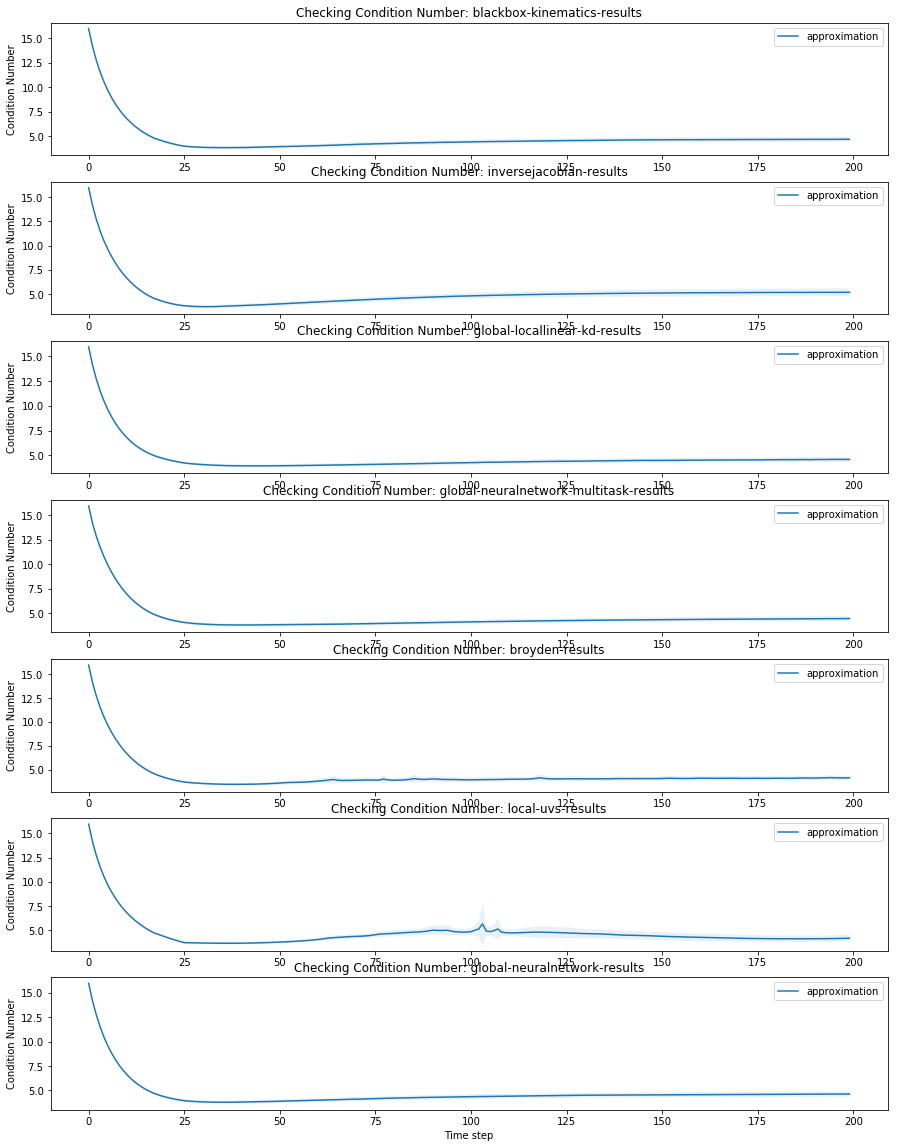

In [36]:
# Checking conditioning of Matrix over episodes & comparing to true jacobian at those points
#Focusing only on the frobenius norm
fig, axs = plt.subplots(len(results.keys()), 1, figsize=(15, 20))

for i, k_v in enumerate(results.items()):
    algorithm, result = k_v[0], k_v[1]
    ax = axs[i]
    cond_hat, cond_true = check_jacobian_condition(result)
        
    plot_mu_sig(cond_hat, label="approximation", ax=ax)
    #plot_mu_sig(cond_true, label="true values", ax=ax)
    if i >= len(axs) - 1:
        ax.set_xlabel('Time step')
    ax.set_ylabel('Condition Number')
    ax.set_title("Checking Condition Number: {}".format(algorithm))
    ax.legend()